In [5]:
# Uninstall conflicting packages
!pip uninstall -y numpy pandas scipy

# Install compatible versions together
!pip install -q numpy==1.26.4 pandas==2.2.2 scipy==1.13.1

# Install gensim and nltk
!pip install -q gensim==4.3.3 nltk

# RESTART RUNTIME AFTER RUNNING THIS OR IT WILL NOT WORK

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 113.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import all package dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from collections import Counter

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [3]:
# This function loads all .txt with the given document name and returns list
def load_documents(doc_type):
    # Initialize articles array
    articles = []

    # Set Google Drive directory path (NEEDS TO BE CHANGED IF FILES IN DIFFERENT LOCATION)
    directory = '/content/drive/MyDrive/WRIT20833_Final_Project/project_data/'

    # Get all files in directory and store as variable
    all_files = os.listdir(directory)

    # Go through each file in line
    # If the file name contains 'doc_type' string at beginning and ends with '.txt', keep it
    doc_files = [f for f in all_files if f.lower().startswith(f'{doc_type}_doc_') and f.lower().endswith('.txt')]

    # Go through each file that matched the name filter above
    for filename in sorted(doc_files):
        filepath = os.path.join(directory, filename)
        try:
            # Open the file with 'r' read option
            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read().strip()
                if text:
                    # Get word count for displaying current processing output status
                    word_count = len(text.split())
                    # Store text for document in string in articles list
                    articles.append(text)
                    # Output current file loaded and number of words
                    print(f"Loaded {filename}: {word_count} words")
        except Exception as e:
            # Display error if exception is thrown
            # Show while file caused the loading error and the reason
            print(f"Error loading {filename}: {e}")

    # Display final success message after all files are loaded and stored properly
    print(f"\nSuccessfully loaded {len(articles)} {doc_type} documents.\n")
    return articles



In [4]:
# Call load_documents function above for each dataset

# Load and store all documents in the soviet dataset
soviet_documents = load_documents('soviet')

# Load and store all documents in the western dataset
western_documents = load_documents('western')

Loaded soviet_doc_1.txt: 6839 words
Loaded soviet_doc_10.txt: 349 words
Loaded soviet_doc_11.txt: 601 words
Loaded soviet_doc_12.txt: 1095 words
Loaded soviet_doc_13.txt: 1086 words
Loaded soviet_doc_14.txt: 3481 words
Loaded soviet_doc_15.txt: 455 words
Loaded soviet_doc_16.txt: 1314 words
Loaded soviet_doc_2.txt: 3053 words
Loaded soviet_doc_3.txt: 93873 words
Loaded soviet_doc_4.txt: 691 words
Loaded soviet_doc_5.txt: 474 words
Loaded soviet_doc_6.txt: 1035 words
Loaded soviet_doc_7.txt: 179 words
Loaded soviet_doc_8.txt: 179 words
Loaded soviet_doc_9.txt: 1231 words

Successfully loaded 16 soviet documents.

Loaded western_doc_1.txt: 51033 words
Loaded western_doc_10.txt: 1104 words
Loaded western_doc_11.txt: 270 words
Loaded western_doc_12.txt: 2308 words
Loaded western_doc_13.txt: 3588 words
Loaded western_doc_14.txt: 320 words
Loaded western_doc_15.txt: 493 words
Loaded western_doc_2.txt: 771 words
Loaded western_doc_3.txt: 1038 words
Loaded western_doc_4.txt: 829 words
Loaded w

In [5]:
# Generic stopwords list from HW3
stopwords = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is",
    "are", "was", "were", "be", "been", "being", "have", "has", "had", "having",
    "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or",
    "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",
    "against", "between", "into", "through", "during", "before", "after", "above",
    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under",
    "again", "further", "then", "once", "here", "there", "when", "where", "why",
    "how", "all", "both", "each", "few", "more", "most", "other", "some", "such",
    "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very",
    "s", "t", "can", "will", "just", "don", "should", "now", "ve", "ll", "amp",
    "also", "would", "could", "get", "go", "one", "two", "see", "time", "way",
    "may", "said", "say", "new", "first", "last", "long", "little", "much",
    "well", "still", "even", "back", "good", "many", "make", "made", "us", "really"
]

# Custom stop words on top of default list given in inital topic analysis assignment

'''These stop words are to filter our analysis to achieve a deeper level of insight instead of
simply the words describing the event. '''

chernobyl_stopwords = ["show", "movie", "review", "screen", "tv", "series",
                    "miniseries", "hbo", "chernobyl", "nuclear",
                      "reactor", "power", "water", "channel", "steam",
                       "page", "fuel", "level", "radiation", "np"]

stopwords.extend(chernobyl_stopwords)

In [6]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# This step normalizes the text and then processes in natural language
def preprocess(text):
    # Make sure text is available to avoid processing errors
    if pd.isna(text):
        return []

    # Convert to lowercase so that words appear the same without capitalization issues
    text = str(text).lower()

    # Remove punctuation and split into individual words
    words = re.findall(r'\b[a-z]+\b', text)

    # Remove stopwords and words less than three characters to get meaningful words
    words = [word for word in words if word not in stopwords and len(word) >= 3]

    # Lemmatize words to reduce to base form and standardize
    words = [lemmatizer.lemmatize(word) for word in words]

    # Return all processed words
    return words

In [7]:
# Initialize empty array to store lists of list of soviet words from each doc after preprocessing
processed_soviet_documents = []

# Initialize empty array to store lists of list of western word from each doc after preprocessing
processed_western_documents = []

# Process each soviet document to extract individual and meaningful words and store
for doc in soviet_documents:
  processed_soviet_documents.append(preprocess(doc))

# Process each western document to extract individual and meaningful words and store
for doc in western_documents:
  processed_western_documents.append(preprocess(doc))

# Output example of text before and after preprocessing to show it works properly
print(f"Original: {soviet_documents[0][:150]}...")
print(f"\nProcessed words: {processed_soviet_documents[0][:150]}")

Original: 1. Report of the Government Commission for Investigation of Causes of the Accident at the Chernobyl NPS [Nuclear Power Station] on 26 April 1986. Gorb...

Processed words: ['report', 'government', 'commission', 'investigation', 'cause', 'accident', 'np', 'station', 'april', 'gorbachev', 'agreed', 'earlier', 'upon', 'completion', 'work', 'government', 'commission', 'investigation', 'cause', 'accident', 'chernoby', 'np', 'address', 'issue', 'politburo', 'session', 'commission', 'delivered', 'report', 'result', 'investigation', 'cde', 'shcherbina', 'floor', 'shcherbina', 'deputy', 'chairman', 'ussr', 'council', 'minister', 'commission', 'delivered', 'report', 'accident', 'np', 'conclusion', 'recommendation', 'adopted', 'commission', 'unanimously', 'report', 'appendix', 'lay', 'cause', 'accident', 'conclusion', 'recommendation', 'stemming', 'analysis', 'situation', 'commission', 'analyzed', 'practically', 'source', 'primary', 'information', 'conclusion', 'institute', 'expert', 'g

In [8]:
# This section is to display a general summary of the stats for each dataset

# Get and store number of meaningful words found in each document in dataset
soviet_doc_lengths = [len(doc) for doc in processed_soviet_documents]
western_doc_lengths = [len(doc) for doc in processed_western_documents]

# Calculate average number of words for each dataset using Numpy
soviet_avg_length = np.mean(soviet_doc_lengths)
western_avg_length = np.mean(western_doc_lengths)

# Combine all words into single list to calculate vocabulary size for each dataset
soviet_words = [word for doc in processed_soviet_documents for word in doc]
western_words = [word for doc in processed_western_documents for word in doc]
soviet_vocab_size = len(set(soviet_words))
western_vocab_size = len(set(western_words))

# Output summary stats in easy to read format
print("SOVIET DATA STATS")
print("=" * 40)
print(f"Number of documents: {len(processed_soviet_documents)}")
print(f"Vocabulary size: {soviet_vocab_size}")
print(f"Average document length: {soviet_avg_length:.1f} words")
print(f"Shortest document: {min(soviet_doc_lengths)} words")
print(f"Longest document: {max(soviet_doc_lengths)} words")
print("")
print("WESTERN DATA STATS")
print("=" * 40)
print(f"Number of documents: {len(processed_western_documents)}")
print(f"Vocabulary size: {western_vocab_size}")
print(f"Average document length: {western_avg_length:.1f} words")
print(f"Shortest document: {min(western_doc_lengths)} words")
print(f"Longest document: {max(western_doc_lengths)} words")

SOVIET DATA STATS
Number of documents: 16
Vocabulary size: 9240
Average document length: 3374.6 words
Shortest document: 80 words
Longest document: 44018 words

WESTERN DATA STATS
Number of documents: 15
Vocabulary size: 5038
Average document length: 2089.9 words
Shortest document: 135 words
Longest document: 24062 words


In [9]:
# Convert each processes document list to dictionary for running LDA model
soviet_dictionary = corpora.Dictionary(processed_soviet_documents)
western_dictionary = corpora.Dictionary(processed_western_documents)

# Convert each processes document list to corpus for running LDA model
soviet_corpus = [soviet_dictionary.doc2bow(doc) for doc in processed_soviet_documents]
western_corpus = [western_dictionary.doc2bow(doc) for doc in processed_western_documents]

# Output dictionary and corpus stats for soviet dataset found by the gensim module
print("SOVIET DICTIONARY AND CORPUS")
print("=" * 40)
print("📖 Dictionary and corpus created!")
print(f"Total unique words in dictionary: {len(soviet_dictionary)}")
print(f"Total documents in corpus: {len(soviet_corpus)}")
print(f"\nExample word-to-ID mappings:")
for i, (word_id, word) in enumerate(list(soviet_dictionary.items())[:10]):
    print(f"  ID {word_id}: {word}")

print("")

# Output dictionary and corpus stats for western dataset found by the gensim module
print("WESTERN DICTIONARY AND CORPUS")
print("=" * 40)
print("📖 Dictionary and corpus created!")
print(f"Total unique words in dictionary: {len(western_dictionary)}")
print(f"Total documents in corpus: {len(western_corpus)}")
print(f"\nExample word-to-ID mappings:")
for i, (word_id, word) in enumerate(list(western_dictionary.items())[:10]):
    print(f"  ID {word_id}: {word}")

SOVIET DICTIONARY AND CORPUS
📖 Dictionary and corpus created!
Total unique words in dictionary: 9240
Total documents in corpus: 16

Example word-to-ID mappings:
  ID 0: able
  ID 1: absence
  ID 2: absolute
  ID 3: absolutely
  ID 4: absorber
  ID 5: absorption
  ID 6: academician
  ID 7: academy
  ID 8: accelerated
  ID 9: acceleration

WESTERN DICTIONARY AND CORPUS
📖 Dictionary and corpus created!
Total unique words in dictionary: 5038
Total documents in corpus: 15

Example word-to-ID mappings:
  ID 0: aaaphh
  ID 1: aaapmi
  ID 2: abagyan
  ID 3: abaphfthbie
  ID 4: abapiw
  ID 5: abapmi
  ID 6: abide
  ID 7: ability
  ID 8: able
  ID 9: abnormal


In [11]:
print(f"Training Soviet LDA model... \n")

# Train soviet LDA model with soviet corpus and dictionary
soviet_lda_model = LdaModel(
    corpus=soviet_corpus,
    id2word=soviet_dictionary,
    num_topics=3,
    random_state=42,
    passes=50,
    iterations=1000,
    alpha='auto',
    eta='auto'
)

# Output all the found topics
print("✅ Final model training complete!\n")
print("DISCOVERED TOPICS")
print("=" * 70)

# Output the relevant words for each topic
for idx in range(3):
    words = soviet_lda_model.show_topic(idx, 10)
    word_list = [word for word, prob in words]
    print(f"\nTopic {idx}: {', '.join(word_list)}")

Training Soviet LDA model... 

✅ Final model training complete!

DISCOVERED TOPICS

Topic 0: station, accident, gorbachev, ministry, people, work, state, measure, building, energy

Topic 1: np, accident, energy, station, work, year, building, thousand, ministry, system

Topic 2: system, unit, control, channel, pressure, accident, zone, safety, signal, heat


In [12]:
print(f"Training Western LDA model... \n")

# Train western LDA model with western corpus and dictionary
western_lda_model = LdaModel(
    corpus=western_corpus,
    id2word=western_dictionary,
    num_topics=3,
    random_state=42,
    passes=50,
    iterations=1000,
    alpha='auto',
    eta='auto'
)

# Output all the found topics
print("✅ Final model training complete!\n")
print("🎯 YOUR DISCOVERED TOPICS")
print("=" * 70)

# Output the relevant words for each topic
for idx in range(3):
    words = western_lda_model.show_topic(idx, 10)
    word_list = [word for word, prob in words]
    print(f"\nTopic {idx}: {', '.join(word_list)}")

Training Western LDA model... 



✅ Final model training complete!

🎯 YOUR DISCOVERED TOPICS

Topic 0: soviet, accident, gorbachev, weapon, proposal, reduction, public, state, sensitive, secret

Topic 1: accident, party, line, disaster, soviet, building, declassified, gorbachev, shcherbitskiy, consequence

Topic 2: accident, design, safety, system, rod, plant, reactivity, control, core, operating


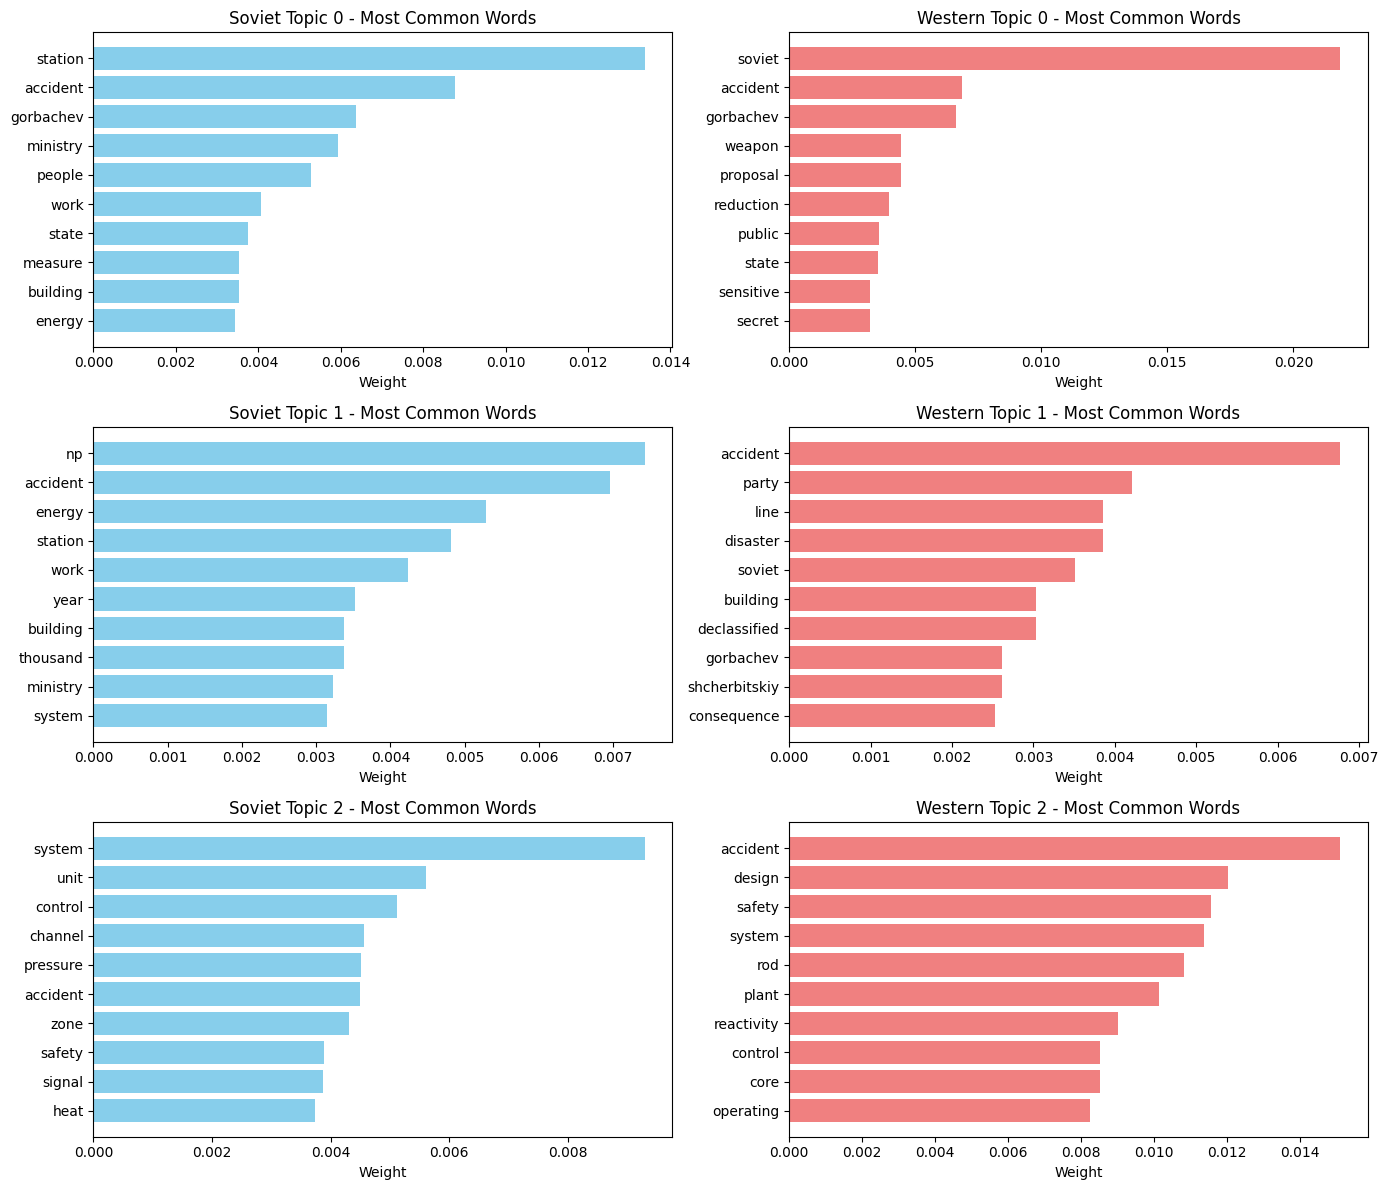

In [14]:
# Create visualization of topics
# One column for soviet topics, one for western topics
fig, axes = plt.subplots(3, 2, figsize=(14, 4*3))

# Go through each topic and get data about topic
for idx in range(3):
    # Get and display soviet topic stats
    soviet_words_weights = soviet_lda_model.show_topic(idx, 10)
    soviet_words = [word for word, weight in soviet_words_weights]
    soviet_weights = [weight for word, weight in soviet_words_weights]

    # Set the axis values and titles
    axes[idx][0].barh(range(len(soviet_words)), soviet_weights, color='skyblue')
    axes[idx][0].set_yticks(range(len(soviet_words)))
    axes[idx][0].set_yticklabels(soviet_words)
    axes[idx][0].set_xlabel('Weight')
    axes[idx][0].set_title(f'Soviet Topic {idx} - Most Common Words')
    axes[idx][0].invert_yaxis()

    # Get and display western topic stats
    western_words_weights = western_lda_model.show_topic(idx, 10)
    western_words = [word for word, weight in western_words_weights]
    western_weights = [weight for word, weight in western_words_weights]

    # Set the axis values and titles
    axes[idx][1].barh(range(len(western_words)), western_weights, color='lightcoral')
    axes[idx][1].set_yticks(range(len(western_words)))
    axes[idx][1].set_yticklabels(western_words)
    axes[idx][1].set_xlabel('Weight')
    axes[idx][1].set_title(f'Western Topic {idx} - Most Common Words')
    axes[idx][1].invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
# Load in the sentiment analysis results to compare sentiments and topics
soviet_df = pd.read_csv('/content/drive/MyDrive/WRIT20833_Final_Project/processed_data/soviet_sentiment.csv')
western_df = pd.read_csv('/content/drive/MyDrive/WRIT20833_Final_Project/processed_data/western_sentiment.csv')

In [ ]:
def compareTopicsAndSentiment(lda_model, corpus, sentiment_series, name):
    # Get topics for each dataset
    doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]

    print(f"SENTIMENT BY TOPIC ANALYSIS: {name}")
    print("=" * 50)

    # Go through each topic and find documents and sentiment stats
    for topic in range(3):
        # Find the specific documents for this topic
        documents = [
            # Make sure a topic distribution exists
            i for i, topic_dist in enumerate(doc_topics)
            if i < len(sentiment_series) and topic_dist
               and max(topic_dist, key=lambda x: x[1])[0] == topic
        ]

        # Show error if no documents found
        if not documents:
            print(f"\nTopic {topic}: No documents found.")
            continue

        # Calculate sentiment stats
        topic_sentiments = sentiment_series.iloc[documents]
        avg_sentiment = topic_sentiments.mean()
        min_sentiment = topic_sentiments.min()
        max_sentiment = topic_sentiments.max()

        # Get all the topic words to display along with stats
        topic_words = lda_model.show_topic(topic, 10)
        word_list = [word for word, prob in topic_words]

        # Output the words and the stats
        print(f"\nTopic {topic}: {', '.join(word_list)}")
        print(f"  Documents: {len(documents)}")
        print(f"  Average sentiment: {avg_sentiment:.3f}")
        print(f"  Sentiment range: {min_sentiment:.3f} to {max_sentiment:.3f}")


# Build and display each sentiment by topic analysis summary
compareTopicsAndSentiment(soviet_lda_model, soviet_corpus, soviet_df['sentiment_score'], name="Soviet")
compareTopicsAndSentiment(western_lda_model, western_corpus, western_df['sentiment_score'], name="Western")




📊 SENTIMENT BY TOPIC ANALYSIS: Soviet

Topic 0: station, accident, gorbachev, ministry, people, work, state, measure, building, energy
  Documents: 5
  Average sentiment: 0.137
  Sentiment range: -0.175 to 0.657

Topic 1: np, accident, energy, station, work, year, building, thousand, ministry, system
  Documents: 6
  Average sentiment: -0.342
  Sentiment range: -0.836 to 0.390

Topic 2: system, unit, control, channel, pressure, accident, zone, safety, signal, heat
  Documents: 1
  Average sentiment: -0.917
  Sentiment range: -0.917 to -0.917

📊 SENTIMENT BY TOPIC ANALYSIS: Western

Topic 0: soviet, accident, gorbachev, weapon, proposal, reduction, public, state, sensitive, secret
  Documents: 9
  Average sentiment: -0.006
  Sentiment range: -0.448 to 0.545

Topic 1: accident, party, line, disaster, soviet, building, declassified, gorbachev, shcherbitskiy, consequence
  Documents: 2
  Average sentiment: 0.150
  Sentiment range: 0.129 to 0.172

Topic 2: accident, design, safety, system,